# Modeling

- Last observed value
- Simple average
- Moving average
- Holt's Linear Trend
- Previous cycle

In [289]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# wrangle
import acquire
import prepare

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

# facebook prophet model
from prophet import Prophet

# ARIMA model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

# Neural Network Model
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.preprocessing.sequence import TimeseriesGenerator

# local files
import prepare

# Wrangle

In [2]:
# read in messy data
df = pd.read_csv('tiktok_data.csv')

In [3]:
# use prepare function to clean
df = prepare.prep_tiktok(df)

In [4]:
# set timt as index
df.set_index('date', inplace=True)
df = df.sort_index()

In [5]:
df.shape

(21551, 12)

In [6]:
# trim off date range
df = df[df.index>='2018-12-01']
df = df[df.index<='2022-09-10']

In [7]:
df.shape

(21429, 12)

In [8]:
df.head()

,comments,likes,views,shares,total_followers,total_likes,total_videos,description,duration,hashtag,category,length
date,,,,,,,,,,,,
2018-12-03,281,121300,1500000,2974,181300,4900000,810,#lamberghini #creativity #fashiondesign #artis...,26,fashionblogger,Fashion,Medium: 15-60s
2018-12-08,2313,1200000,12000000,26300,465600,7600000,175,Sprinklers ‚ù§Ô∏èüòçüòã #recipe #foodpost #f...,24,food,Food,Medium: 15-60s
2018-12-08,2313,1200000,12000000,26300,465600,7600000,175,Sprinklers ‚ù§Ô∏èüòçüòã #recipe #foodpost #f...,24,foodlover,Food,Medium: 15-60s
2018-12-09,7009,2700000,18600000,60300,14400000,304000000,802,Squad Up !!! #justdancemoves #Fitness #Fun,9,fitness,Fitness & Lifestyle,Short: 0-15s
2018-12-09,7004,2700000,18600000,60300,14400000,304100000,804,Squad Up !!! #justdancemoves #Fitness #Fun,9,fun,Humor,Short: 0-15s


In [10]:
# resample on week
resample = df.resample('w')[['views']].sum()

In [11]:
resample.head()

,views
date,
2018-12-09,62700000
2018-12-16,16759600
2018-12-23,0
2018-12-30,539600
2019-01-06,3600000


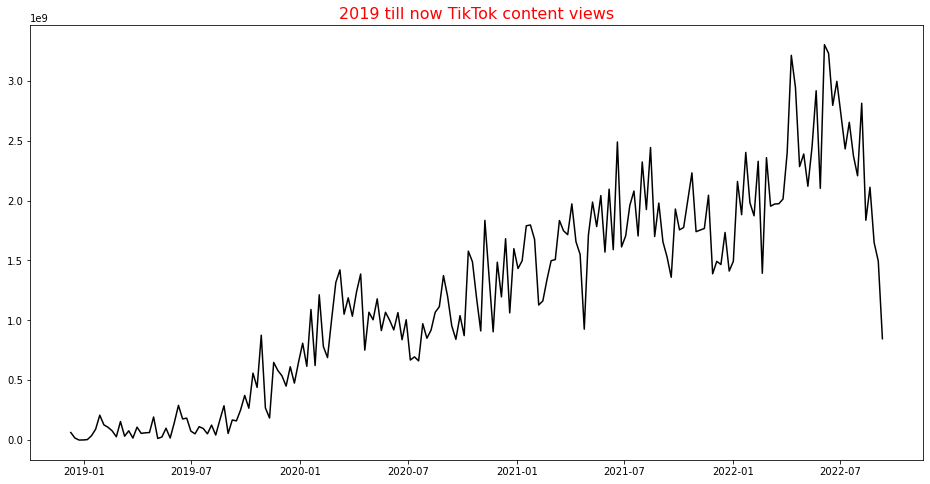

In [12]:
# views
plt.figure(figsize = (16,8))
plt.title('2019 till now TikTok content views', fontsize = 16, color = 'red')
plt.plot(resample.index, resample.views, color = 'black')

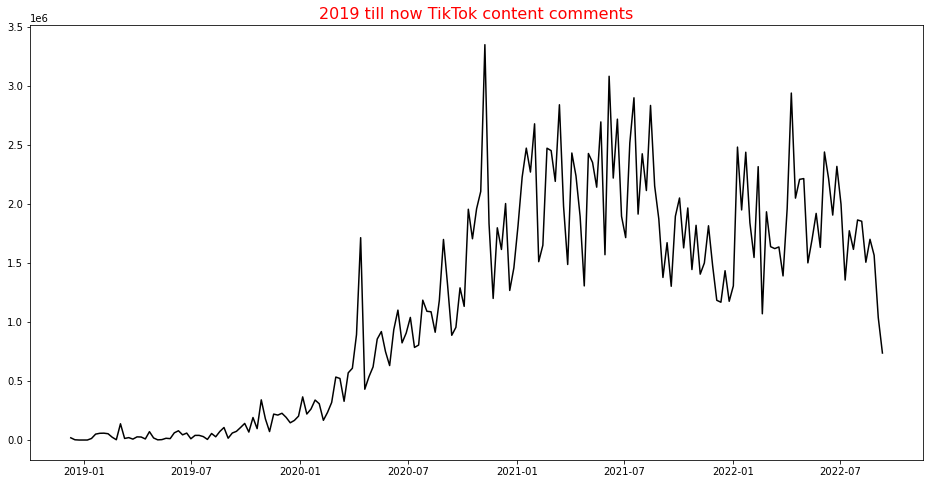

In [210]:
# comments
plt.figure(figsize = (16,8))
plt.title('2019 till now TikTok content comments', fontsize = 16, color = 'red')
plt.plot(resample.index, resample.comments, color = 'black')

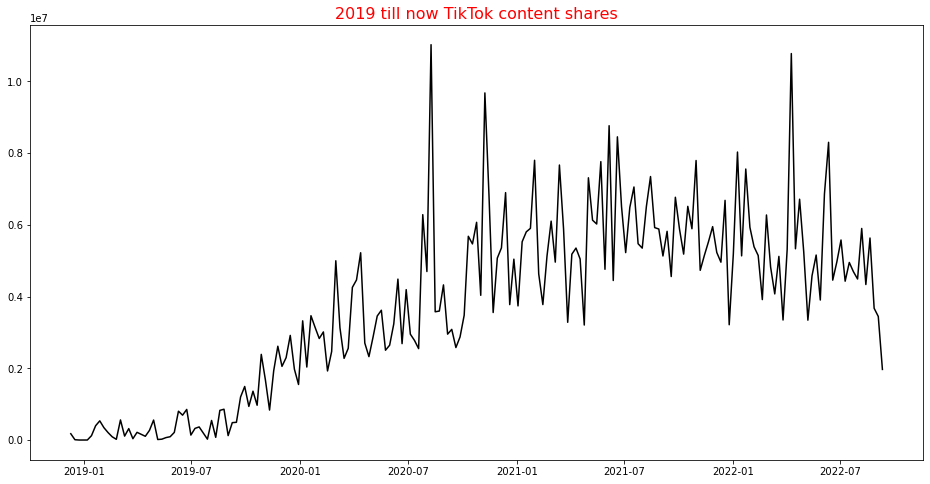

In [211]:
# shares
plt.figure(figsize = (16,8))
plt.title('2019 till now TikTok content shares', fontsize = 16, color = 'red')
plt.plot(resample.index, resample.shares, color = 'black')

***

# Split Data

- We will use the training proportion method to split.
- Identify the total length of the dataframe and multiply by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)
- Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.
- Return train and test dataframes.

In [13]:
# check df size
resample.shape

(197, 1)

In [14]:
# set train size to be 50% of total 
train_size = int(round(resample.shape[0] * 0.5)+1)
train_size

99

In [15]:
# set validate size to be 30% of total 
validate_size = int(round(resample.shape[0] * 0.3))
validate_size

59

In [16]:
# set test size to be number of rows remaining. 
test_size = int(round(resample.shape[0] * 0.2))
test_size

39

In [17]:
len(resample) == train_size + validate_size + test_size

True

In [18]:
# validate will go from 689 to 689+413
validate_end_index = train_size + validate_size
validate_end_index

158

**NOTE: Use above values to split our dataframe**

In [19]:
# train
train = resample[:train_size]

In [20]:
# validate
validate = resample[train_size:validate_end_index]

In [21]:
# verify train tail and validate head
train.tail()

,views
date,
2020-09-27,1039307300
2020-10-04,872048800
2020-10-11,1577750000
2020-10-18,1488575200
2020-10-25,1183640000


In [22]:
# verify train tail and validate head
validate.head()

,views
date,
2020-11-01,911124200
2020-11-08,1834715400
2020-11-15,1366401600
2020-11-22,903935600
2020-11-29,1485446000


In [23]:
# verify validate tail and test head
validate.tail()

,views
date,
2021-11-14,1767148200
2021-11-21,2044670700
2021-11-28,1388387400
2021-12-05,1492639600
2021-12-12,1465915400


In [24]:
# test will include 1103 to the end
test = resample[validate_end_index:]

In [25]:
# verify validate tail and test head
test.head()

,views
date,
2021-12-19,1733652700
2021-12-26,1411379600
2022-01-02,1492905900
2022-01-09,2159629600
2022-01-16,1881999700


In [26]:
# check size
train.shape[0], validate.shape[0], test.shape[0]

(99, 59, 39)

## Verify Split

- Does the length of each df equate to the length of the original df?

In [27]:
# is len of train + validate + test == lenght of entire dataframe. 
len(train) + len(validate) + len(test) == len(resample)

True

- Does the first row of original df equate to the first row of train?

In [227]:
print(resample.head(1) == train.head(1))

            comments  likes  views  shares
date                                      
2018-12-09      True   True   True    True


- Is the last row of train the day before the first row of validate? And the same for validate to test?

In [228]:
# verified
pd.concat([train.tail(1), validate.head(1)])

,comments,likes,views,shares
date,,,,
2020-10-25,1961082,189205842,1183640000,6068547
2020-11-01,2107585,142578523,911124200,4033655


In [229]:
# verifed
pd.concat([validate.tail(1), test.head(1)])

,comments,likes,views,shares
date,,,,
2021-12-12,1168227,175212877,1465915400,4957000
2021-12-19,1435453,216717639,1733652700,6680092


- Is the last row of test the same as the last row of our original dataframe?

In [34]:
pd.concat([test.tail(1), resample.tail(1)])

,comments,likes,views,shares
date,,,,
2022-09-11,737654,111279769,846219800,1967877
2022-09-11,737654,111279769,846219800,1967877


### Let's plot our data, viewing where the data is split into train and test.

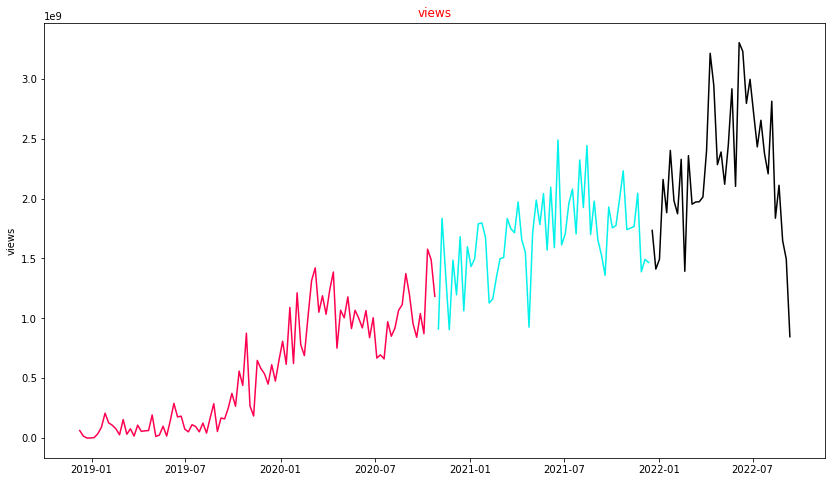

In [28]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color = '#ff0050')
    plt.plot(validate[col], color = '#00f2ea')
    plt.plot(test[col], color = '#000000')
    plt.ylabel(col)
    plt.title(col, color = 'red')
    plt.show()

# Evaluation Functions

In [29]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [30]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start.

In [31]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [32]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [33]:
def make_predictions(views=None, likes=None):
    yhat_df = pd.DataFrame({'views': [views],
                           'likes': [likes]},
                          index=validate.index)
    return yhat_df

# Forecasting

- Last Observed Value (Baseline)
- Moving Average: The future will look, on average, like recent history.
- Holt's Linear Trend
- Previous Cycle
- Facebook Prophet

## Baseline (Last Observed Value)

#### Views

In [231]:
train['views'][-1:][0]

1183640000

In [232]:
# take the last item of sales total and assign to variable
last_views = train['views'][-1:][0]
last_views

1183640000

#### Likes

In [482]:
# take the last item of quantity and assign to variable
last_likes = train['likes'][-1:][0]
last_likes

189205842

In [483]:
yhat_df = pd.DataFrame(
    {'views': [last_views],
     'likes': [last_likes]},
    index=validate.index)

yhat_df.head()

,views,likes
date,,
2020-11-01,1183640000,189205842
2020-11-08,1183640000,189205842
2020-11-15,1183640000,189205842
2020-11-22,1183640000,189205842
2020-11-29,1183640000,189205842


#### Plot Actual vs. Predicted Values

views -- RMSE: 599773169


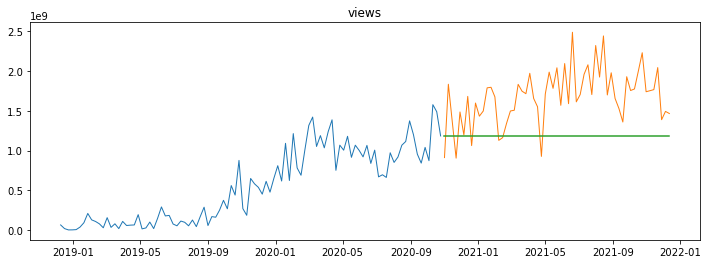

In [46]:
plot_and_eval('views')

#### Evaluate

In [237]:
for col in train[['views', 'likes']]:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,views,599773169.0
1,last_observed_value,likes,49665961.0
2,30d_moving_avg,views,730849085.0
3,30d_moving_avg,likes,95132821.0
4,4_day_moving_avg,views,730849085.0
5,4_day_moving_avg,likes,95132821.0
6,12_day_moving_avg,views,730849085.0
7,12_day_moving_avg,likes,95132821.0
8,26_day_moving_avg,views,730849085.0
9,26_day_moving_avg,likes,95132821.0


In [235]:
min_views_rmse = eval_df[eval_df.target_var == 'views']['rmse'].min()
min_views_rmse

349329760.0

In [236]:
min_likes_rmse = eval_df[eval_df.target_var == 'likes']['rmse'].min()
min_likes_rmse

49665961.0

**Test Evaluation**

In [485]:
rmse = round(sqrt(mean_squared_error(test['views'], yhat_df['views'].tail(39))), 0)
rmse

1186178769.0

## Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

In [50]:
print(train['views'].rolling(30).mean())

date
2018-12-09             NaN
2018-12-16             NaN
2018-12-23             NaN
2018-12-30             NaN
2019-01-06             NaN
                  ...     
2020-09-27    1.016005e+09
2020-10-04    9.976966e+08
2020-10-11    1.015253e+09
2020-10-18    1.025274e+09
2020-10-25    1.030266e+09
Freq: W-SUN, Name: views, Length: 99, dtype: float64


#### Make Predictions

In [51]:
period=30
train['views'].rolling(period).mean()[-1]

1030266475.5333333

In [301]:
period = 30 

# take 30 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
rolling_views = round(train['views'].rolling(period).mean()[-1], 2)
rolling_likes = round(train['likes'].rolling(period).mean()[-1], 2)
print(rolling_views, rolling_likes)

1030266475.53 132685506.53


In [298]:
yhat = make_predictions(rolling_views, rolling_likes)
yhat.head()

,views,likes
date,,
2020-11-01,1.030266e+09,1.326855e+08
2020-11-08,1.030266e+09,1.326855e+08
2020-11-15,1.030266e+09,1.326855e+08
2020-11-22,1.030266e+09,1.326855e+08
2020-11-29,1.030266e+09,1.326855e+08


#### Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

views -- RMSE: 730849085


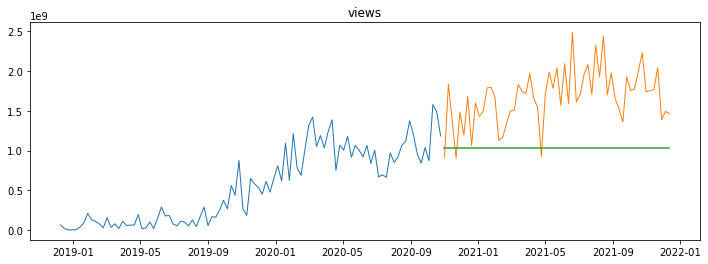

likes -- RMSE: 95132821


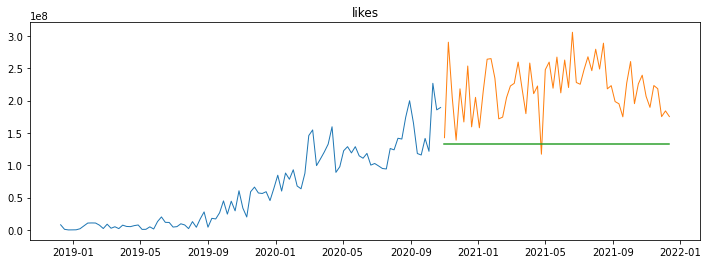

In [54]:
for col in train[['views', 'likes']]:
    plot_and_eval(col)

#### Evaluate

In [55]:
for col in train[['views', 'likes']]:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,views,599773169.0
1,last_observed_value,likes,49665961.0
2,30d_moving_avg,views,730849085.0
3,30d_moving_avg,likes,95132821.0


Let's try out several other values for periods:

In [56]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_sales = round(train['views'].rolling(p).mean()[-1], 2)
    rolling_quantity = round(train['likes'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions(rolling_views, rolling_likes)
    model_type = str(p) + '_day_moving_avg'
    for col in train[['views', 'likes']]:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [57]:
# which is best so far?
eval_df

,model_type,target_var,rmse
0,last_observed_value,views,599773169.0
1,last_observed_value,likes,49665961.0
2,30d_moving_avg,views,730849085.0
3,30d_moving_avg,likes,95132821.0
4,4_day_moving_avg,views,730849085.0
5,4_day_moving_avg,likes,95132821.0
6,12_day_moving_avg,views,730849085.0
7,12_day_moving_avg,likes,95132821.0
8,26_day_moving_avg,views,730849085.0
9,26_day_moving_avg,likes,95132821.0


In [58]:
# min rmse for views
min_views_rmse = eval_df[eval_df.target_var == 'views']['rmse'].min()

In [59]:
min_views_rmse

599773169.0

In [60]:
eval_df[eval_df.rmse == min_views_rmse]

,model_type,target_var,rmse
0,last_observed_value,views,599773169.0


In [61]:
# min rmse for likes
min_likes_rmse = eval_df[eval_df.target_var == 'likes']['rmse'].min()

In [62]:
min_likes_rmse

49665961.0

## Holt's Linear Trend

In [284]:
col = 'views' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped=True)

In [285]:
# fit the holt's object
model = model.fit(optimized=True)

In [289]:
val_predict = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [291]:
rmse = round(sqrt(mean_squared_error(validate['views'], val_predict)), 0)
rmse

349329760.0

In [65]:
for col in train[['views', 'likes']]:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

#### Plot Actual vs. Predicted Values

views -- RMSE: 349329760


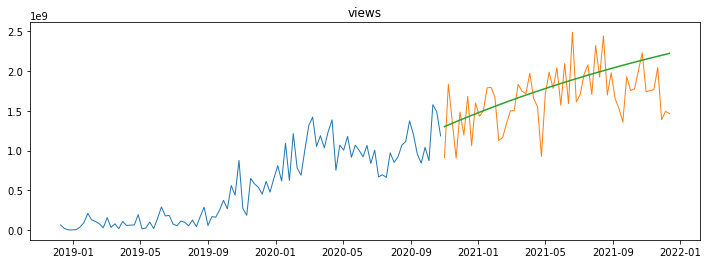

likes -- RMSE: 72559877


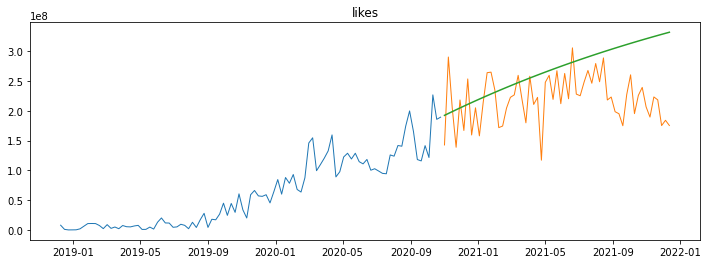

In [66]:
for col in train[['views', 'likes']]:
    plot_and_eval(target_var = col)

#### Evaluate

In [67]:
for col in train[['views', 'likes']]:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [70]:
eval_df[eval_df.target_var =='views'].sort_values(by='rmse').head(10)

,model_type,target_var,rmse
14,holts_optimized,views,349329760.0
0,last_observed_value,views,599773169.0
2,30d_moving_avg,views,730849085.0
4,4_day_moving_avg,views,730849085.0
6,12_day_moving_avg,views,730849085.0
8,26_day_moving_avg,views,730849085.0
10,52_day_moving_avg,views,730849085.0
12,104_day_moving_avg,views,730849085.0


## Facebook Prophet

In [300]:
fbb_train = pd.DataFrame({'ds':train.index, 'y': train.views})

In [292]:
fbb_train.y.mean()

553164766.3838384

In [293]:
fbb_train.fillna(553164766, inplace = True)

In [303]:
m1 = Prophet(changepoint_range=0.5,changepoint_prior_scale=0.75)
m1.fit(fbb_train)

09:08:30 - cmdstanpy - INFO - Chain [1] start processing
09:08:30 - cmdstanpy - INFO - Chain [1] done processing


In [304]:
futuree = m1.make_future_dataframe(periods = 59, freq = 'W')
futuree.tail()

,ds
153,2021-11-14
154,2021-11-21
155,2021-11-28
156,2021-12-05
157,2021-12-12


In [305]:
# make prediction
forecastt = m.predict(futuree)
forecastt[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
153,2021-11-14,1.921597e+09,1.653026e+09,2.196162e+09
154,2021-11-21,1.875590e+09,1.609437e+09,2.140825e+09
155,2021-11-28,1.829786e+09,1.567509e+09,2.122558e+09
156,2021-12-05,1.845044e+09,1.568975e+09,2.110268e+09
157,2021-12-12,1.921935e+09,1.649361e+09,2.193954e+09


In [307]:
forecastt.set_index('ds', inplace = True)

In [310]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train.views, mode='lines',
                    name='train', marker = dict(color='#D7B1FA')))

fig.add_trace(go.Scatter(x=validate.index, y=validate.views, mode='lines',
                    name='validate', marker = dict(color='#6975AB')))

fig.add_trace(go.Scatter(x=forecastt.tail(59).index, y=forecastt.tail(59).yhat,
                    mode='lines',
                    name='prediction', marker = dict(color='#E80F88')))

fig.update_layout(paper_bgcolor="#202020", plot_bgcolor='#202020', font_color='#f3e2fe', font_size = 14, height = 500
                 ,title='Past Total Engagement vs. Model Prediction for Future',
                   xaxis_title='Date',
                   yaxis_title='Total Engagement')

***

In [149]:
new_train = resample[:158]

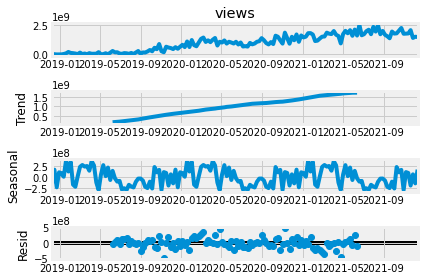

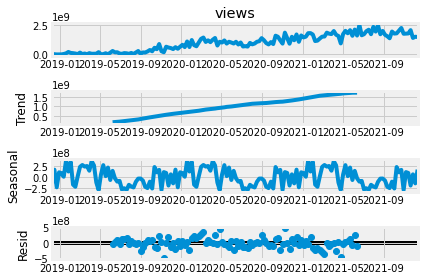

In [290]:
sm.tsa.seasonal_decompose(new_train.views).plot()

In [150]:
new_test = resample[158:]

In [152]:
fb_train = pd.DataFrame({'ds':new_train.index, 'y': new_train.views})

In [153]:
fb_train.y.mean()

972279835.8987342

In [127]:
fb_train.fillna(972279835, inplace = True)

In [154]:
m = Prophet(changepoint_range=0.5,changepoint_prior_scale=0.75)
m.fit(fb_train)

14:37:29 - cmdstanpy - INFO - Chain [1] start processing
14:37:29 - cmdstanpy - INFO - Chain [1] done processing


In [174]:
future = m.make_future_dataframe(periods = 39, freq = 'W')
future.tail()

,ds
192,2022-08-14
193,2022-08-21
194,2022-08-28
195,2022-09-04
196,2022-09-11


In [158]:
# make prediction
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
192,2022-08-14,2.504924e+09,2.198478e+09,2.844857e+09
193,2022-08-21,2.544038e+09,2.231953e+09,2.872498e+09
194,2022-08-28,2.566828e+09,2.244265e+09,2.901222e+09
195,2022-09-04,2.498468e+09,2.191418e+09,2.824008e+09
196,2022-09-11,2.357763e+09,2.053835e+09,2.675811e+09


**Validate**

<AxesSubplot:xlabel='date'>

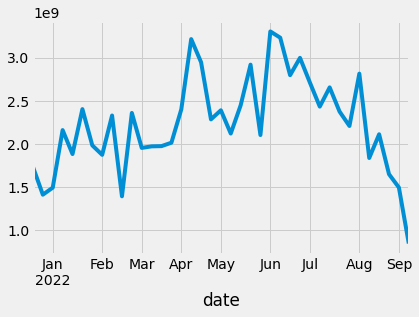

In [160]:
fb_test.views.plot()

**Prediction**

<AxesSubplot:>

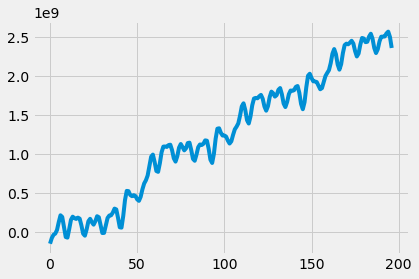

In [161]:
plt.style.use('fivethirtyeight')
forecast.yhat.plot()

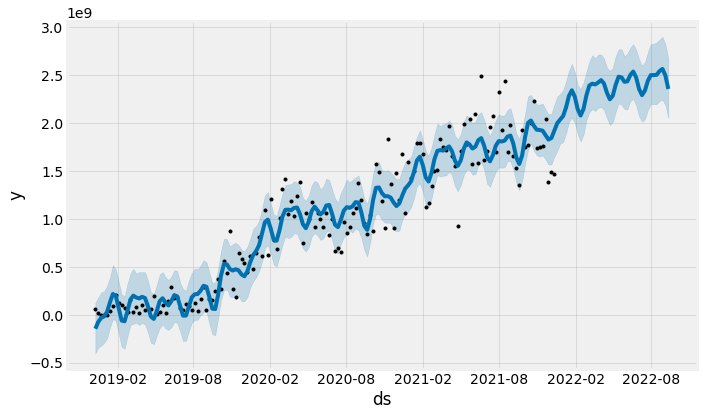

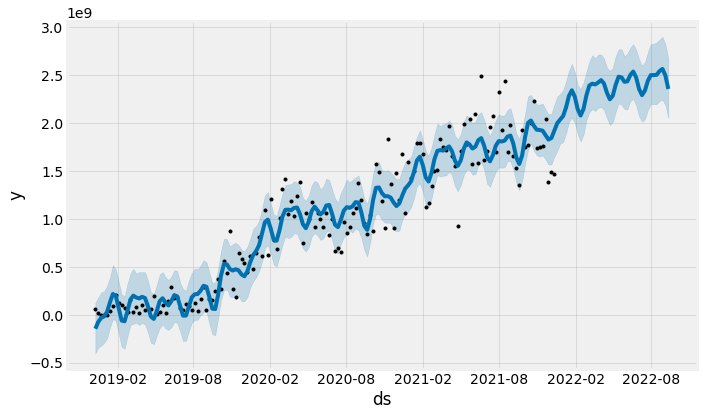

In [162]:
# plot the forecast
m.plot(forecast)

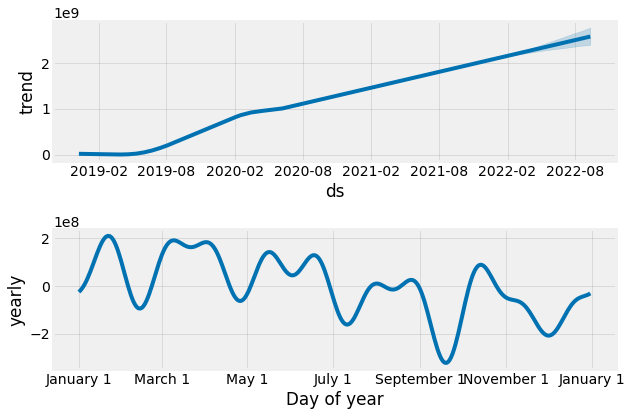

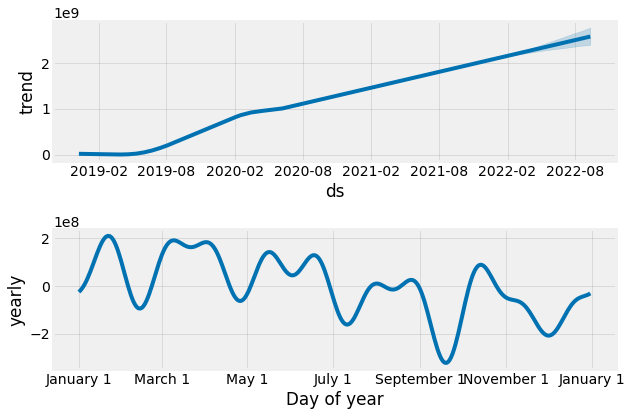

In [163]:
# trend, yearly seasonality, and weekly seasonality of the time series
m.plot_components(forecast)

In [164]:
# interactive figure of the forecast and components
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)


In [165]:
plot_components_plotly(m, forecast)

[[<matplotlib.lines.Line2D at 0x7ffcb8ccd040>],

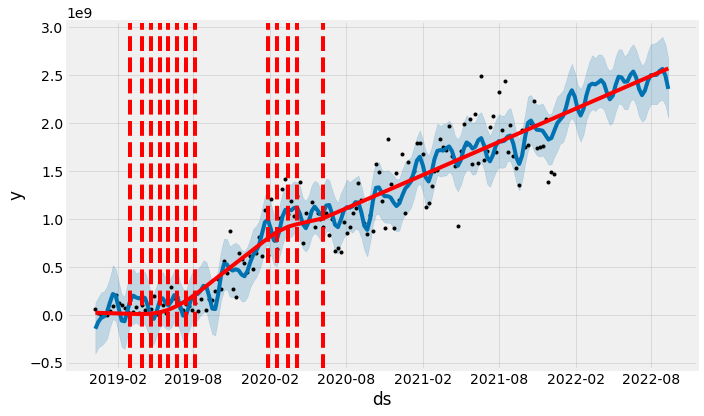

In [166]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
add_changepoints_to_plot(fig.gca(),m,forecast)

In [171]:
rmse = round(sqrt(mean_squared_error(new_test['views'], forecast['yhat'].tail(39))), 0)
rmse

525030148.0

**Predict the Future**

In [248]:
future = m.make_future_dataframe(periods = 96, freq = 'W')
future.tail()

,ds
249,2023-09-17
250,2023-09-24
251,2023-10-01
252,2023-10-08
253,2023-10-15


In [268]:
future_forecast = m.predict(future)

In [269]:
graph_df = future_forecast.tail(58)

In [270]:
graph_df.at[196, 'yhat'] = 846219800

In [271]:
graph_df.at[253, 'yhat'] = 3415801000*1.2

In [272]:
graph_df.set_index('ds', inplace=True)

<AxesSubplot:>

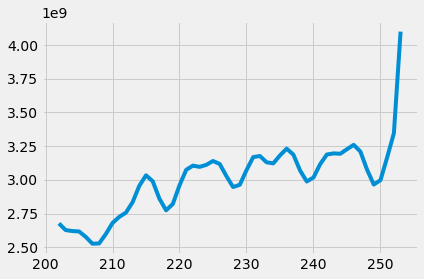

In [273]:
plt.style.use('fivethirtyeight')
future_forecast.yhat.tail(52).plot()

[[<matplotlib.lines.Line2D at 0x7ffcca479160>],

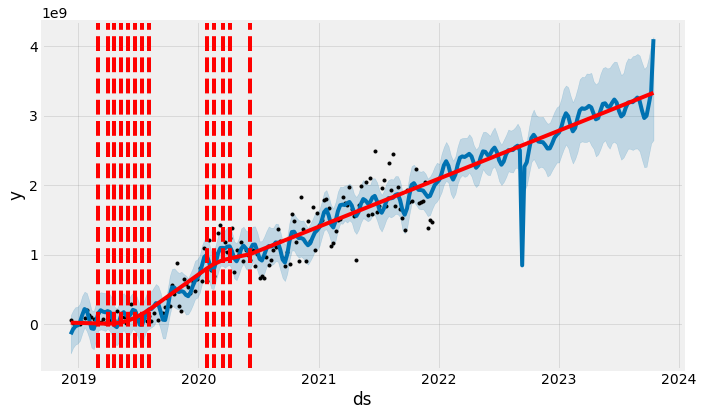

In [274]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(future_forecast)
add_changepoints_to_plot(fig.gca(),m,future_forecast)

In [280]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=resample.index, y=resample.views, mode='lines',
                    name='Past (Dec 2019 to Sep 2022)', marker = dict(color='#3C567F')))

fig.add_trace(go.Scatter(x=graph_df.index, y=graph_df.yhat,
                    mode='lines',
                    name='Future (Sep 2022 to Sep 2023)', marker = dict(color='#E80F88')))

fig.update_layout(paper_bgcolor="#202020", plot_bgcolor='#202020', font_color='#f3e2fe', font_size = 14, height = 500
                 ,title='Past Total Engagement vs. Model Prediction for Future',
                   xaxis_title='Date',
                   yaxis_title='Total Engagement')

In [276]:
# 2022 historic
mean_2022 = resample[(resample.index<'2022-12-31') & (resample.index>'2022-01-01')].views.mean()
mean_2022

2271657764.864865

In [277]:
# now - 2023 September
future_mean = graph_df.yhat.mean()
future_mean

2921826149.2899837

In [278]:
(future_mean-mean_2022)/mean_2022

0.2862087742621723

## Autoregressive Integrated Moving Average (ARIMA)

- First parameter:  the lagging (past values)
- Second parameter:  differencing (this is what makes non-stationary data stationary)
- Last parameter: white noise (for modeling shock events). 

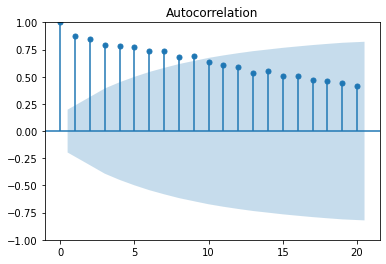

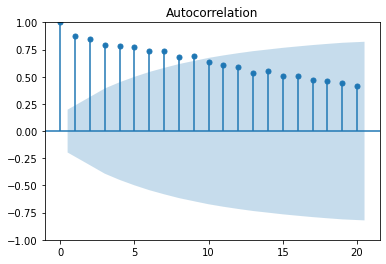

In [180]:
# autocorrelation plot
plot_acf(train.views)

#### 1st Order Differencing

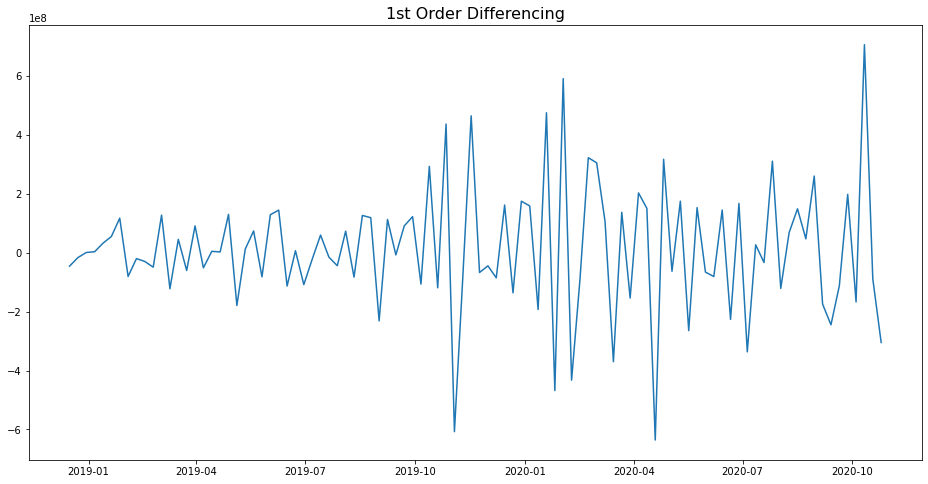

In [184]:
# visualize how the differencing segment of ARIMA makes the data stationary.
plt.figure(figsize =(16,8))
plt.title('1st Order Differencing', fontsize = 16)
plt.plot(train.views.diff())

<Figure size 1152x576 with 0 Axes>

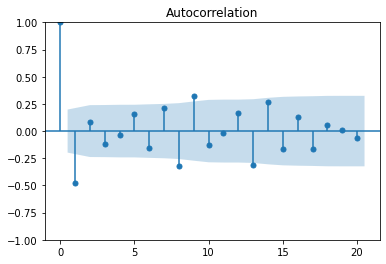

In [187]:
plt.figure(figsize = (16,8))
plot_acf(train.views.diff().dropna())
plt.show()

#### 2nd Order Differencing

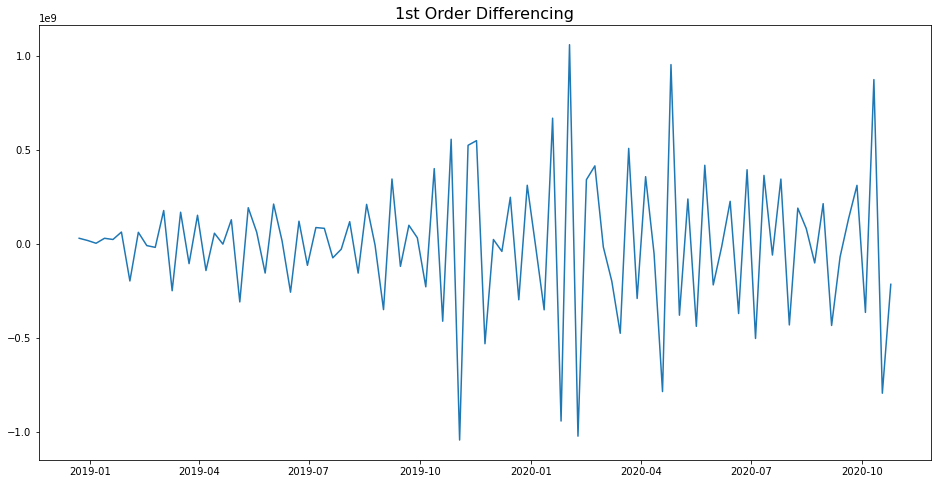

In [194]:
# visualize how the differencing segment of ARIMA makes the data stationary.
plt.figure(figsize =(16,8))
plt.title('1st Order Differencing', fontsize = 16)
plt.plot(train.views.diff().diff())

<Figure size 1152x576 with 0 Axes>

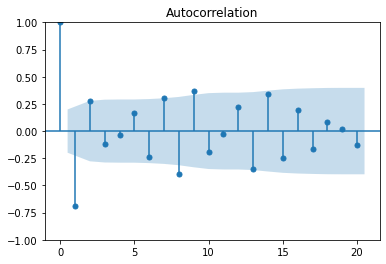

In [188]:
plt.figure(figsize = (16,8))
plot_acf(train.views.diff().diff().dropna())
plt.show()

In [239]:
result = adfuller(train.views.dropna())
print('p-value: ', result[1])

result = adfuller(train.views.diff().dropna())
print('p-value: ', result[1])

result = adfuller(train.views.diff().diff().dropna())
print('p-value: ', result[1])

p-value:  0.9108117394338779
p-value:  1.5858158373823794e-12
p-value:  1.9816398341498166e-08


#### Fit ARIMA Model

In [268]:
# (1,1,2)
arima_model = ARIMA(train.views, order = (1,1,2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  views   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2004.182
Date:                Mon, 03 Oct 2022   AIC                           4016.364
Time:                        20:57:54   BIC                           4026.704
Sample:                    12-09-2018   HQIC                          4020.546
                         - 10-25-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4620      1.672     -0.276      0.782      -3.739       2.815
ma.L1         -0.1821      1.690     -0.108      0.914      -3.494       3.130
ma.L2         -0.2447      1.077     -0.227      0.8

In [37]:
# (1,2,1)
arima_model = ARIMA(train.views, order = (1,2,1))
model = arima_model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  views   No. Observations:                   99
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1993.489
Date:                Tue, 04 Oct 2022   AIC                           3992.979
Time:                        14:20:19   BIC                           4000.703
Sample:                    12-09-2018   HQIC                          3996.102
                         - 10-25-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4840      0.113     -4.291      0.000      -0.705      -0.263
ma.L1         -0.9872      0.105     -9.365      0.000      -1.194      -0.781
sigma2      5.717e+16   7.27e-19   7.86e+34      0.0

In [38]:
ARMA_forecast = model.predict(start = 99, end= 157, dynamic= True)  

In [39]:
validate_rmse = round(sqrt(mean_squared_error(validate['views'], ARMA_forecast)), 0)
validate_rmse

320562470.0

**Test Evaluation**

In [471]:
test.shape

(39, 4)

In [472]:
test.index

DatetimeIndex(['2021-12-19', '2021-12-26', '2022-01-02', '2022-01-09',
               '2022-01-16', '2022-01-23', '2022-01-30', '2022-02-06',
               '2022-02-13', '2022-02-20', '2022-02-27', '2022-03-06',
               '2022-03-13', '2022-03-20', '2022-03-27', '2022-04-03',
               '2022-04-10', '2022-04-17', '2022-04-24', '2022-05-01',
               '2022-05-08', '2022-05-15', '2022-05-22', '2022-05-29',
               '2022-06-05', '2022-06-12', '2022-06-19', '2022-06-26',
               '2022-07-03', '2022-07-10', '2022-07-17', '2022-07-24',
               '2022-07-31', '2022-08-07', '2022-08-14', '2022-08-21',
               '2022-08-28', '2022-09-04', '2022-09-11'],
              dtype='datetime64[ns]', name='date', freq='W-SUN')

In [40]:
test_forecast = model.predict(start = 158, end = 196, dynamic = True)

In [41]:
test_rmse = round(sqrt(mean_squared_error(test['views'],test_forecast)), 0)
test_rmse

554344013.0

## LSTM Neural Network

In [44]:
train_a = train.views

In [47]:
# generate 12 months of dates
n_input = 12
generator = TimeseriesGenerator(train_a.values, train_a.values, length=n_input, batch_size=1)

In [48]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [49]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2022-10-04 14:22:00.641608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [51]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
87/87 [==============================] - 1s 3ms/step - loss: 134685595967422464.0000
Epoch 2/50
87/87 [==============================] - 0s 3ms/step - loss: nan      
Epoch 3/50
87/87 [==============================] - 0s 3ms/step - loss: nan
Epoch 4/50
87/87 [==============================] - 0s 3ms/step - loss: nan
Epoch 5/50
87/87 [==============================] - 0s 3ms/step - loss: nan
Epoch 6/50
87/87 [==============================] - 0s 3ms/step - loss: nan
Epoch 7/50
87/87 [==============================] - 0s 3ms/step - loss: nan
Epoch 8/50
87/87 [==============================] - 0s 3ms/step - loss: nan
Epoch 9/50
87/87 [==============================] - 0s 3ms/step - loss: nan
Epoch 10/50
87/87 [==============================] - 0s 3ms/step - loss: nan
Epoch 11/50
87/87 [==============================] - 0s 3ms/step - loss: nan
Epoch 12/50
87/87 [==============================] - 0s 3ms/step - loss: nan
Epoch 13/50
87/87 [==============================] - 0s 3ms

In [52]:
last_train_batch = train_a.values[-20:]

In [53]:
last_train_batch = last_train_batch.reshape((1,20,1))

In [54]:
last_train_batch

array([[[1064424800],
        [ 837833000],
        [1004816600],
        [ 668104300],
        [ 694708600],
        [ 661200700],
        [ 971582300],
        [ 850180000],
        [ 918163000],
        [1066928200],
        [1113622700],
        [1373497700],
        [1198901300],
        [ 954014000],
        [ 841419600],
        [1039307300],
        [ 872048800],
        [1577750000],
        [1488575200],
        [1183640000]]])

In [384]:
validate.views[0]

911124200

In [55]:
test_predictions = []

first_eval_batch = train_a.values[-n_input:]
current_batch = first_eval_batch.reshape((1, 12, 1))

for i in range(len(validate)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 17ms/step


In [57]:
pred = []
for i in range(0, 59):
    

    pred.append(test_predictions[i][0])

In [60]:
validate['pred']= pred

In [61]:
validate.head()

,views,pred
date,,
2020-11-01,911124200,NaN
2020-11-08,1834715400,NaN
2020-11-15,1366401600,NaN
2020-11-22,903935600,NaN
2020-11-29,1485446000,NaN


<AxesSubplot:xlabel='date'>

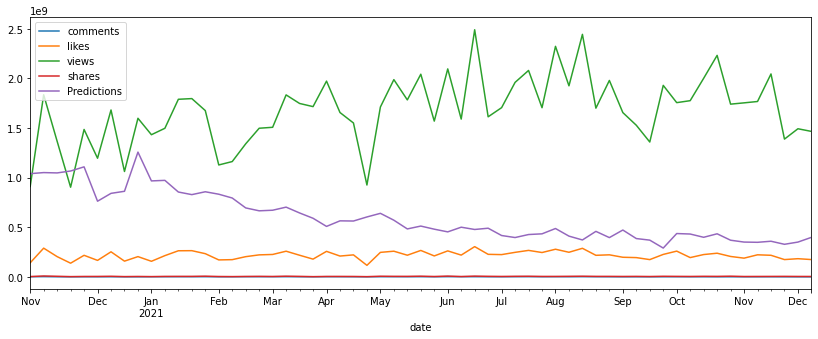

In [437]:
validate.plot(figsize=(14,5))

In [415]:
rmse=sqrt(mean_squared_error(validate.views,pred))
print(rmse)

1186402819.9309504


#### Resample by Day (2018-12-01 - 2022-09-10) - Validate
- Baseline Views RMSE: 120066387

- Rolling Average RMSE: 120259456

- Facebook Prophet Views: 109683655 (outperform by 8.6%)

#### Resample by Week (2018-12-01 - 2022-09-10) - Validate
- Baseline Views RMSE: 599773169
- Rolling Average RMSE: 599773169
- Holt's RMSE: 349329760
- Facebook: 322011088 (46.3%)
    - weekly_seasonality=False, changepoint_range=1,changepoint_prior_scale=0.75 464053600
    - weekly_seasonality=False, changepoint_range=1,changepoint_prior_scale=0.5 365801236
    - weekly_seasonality=False, changepoint_range=0.5,changepoint_prior_scale=0.75 323347218
    - weekly_seasonality=False, changepoint_range=0.3,changepoint_prior_scale=0.5 354942242
    - weekly_seasonality=False, changepoint_range=0.5,changepoint_prior_scale=0.5 618014950

####  Resample by Week (2018-12-01 - 2022-09-10) - Test
- Baseline on Test: 1186178769
- Facebook Prophet: 525030148 (56%)
- ARIMA: 554344013 (53%)

In [486]:
# ARIMA
(1186178769-554344013)/1186178769

0.5326640237648698

In [172]:
# FACEBOOK
(1186178769-525030148)/1186178769

0.5573768796733538